Team DJ: David Íñiguez Gómez and Jaime Sánchez Salazar

# Imports

In [5]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import xgboost as xgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK

import tensorflow as tf
!pip install transformers
from transformers import TFDistilBertForSequenceClassification,DistilBertTokenizer

# Dataset A (Derma)

## Some definitions of functions

In [6]:
def normalize(df, minimum=None):
    if minimum is None:
        minimum = df.min()
    maximum = df.max()
    df -= minimum
    df /= maximum - minimum

def preprocess(df, y=False):
    if y:
        df = df.replace('fake', 0)
        df = df.replace('real', 1)
        return df
    # Delete columns:
    vars_delete = ['Id', 'Doughnuts consumption']
    df = df.drop(vars_delete, axis=1, inplace=False)
    # Normalize:
    vars_normalize = ['Genetic Propensity', 'Skin X test']#, 'Doughnuts consumption']
    for v in vars_normalize:
        if v == 'Skin X test':
            minimum = 1
        else:
            minimum = None
        normalize(df[v], minimum=minimum)
    return df

def unified_measure (d, names):
    final = []
    for i in range(len(d['Small'])):
        ns = d[names[0]][i]; nm = d[names[1]][i]; nl = d[names[2]][i]
        if ns == 0:
            if nm == 0:
                if nl == 0:
                    final.append('I')
                elif nl == 1:
                    final.append('L')
                elif math.isnan(nl) == True:
                    final.append('PL')
            elif nm == 1:
                if nl == 0:
                    final.append('M')
                elif nl == 1:
                    final.append('I')
                elif math.isnan(nl) == True:
                    final.append('M')
            elif math.isnan(nm) == True:
                if nl == 0:
                    final.append('PM')
                elif nl == 1:
                    final.append('L')
                elif math.isnan(nl) == True:
                    final.append('ML')
        elif ns == 1:
            if nm == 0:
                if nl == 0:
                    final.append('S')
                elif nl == 1:
                    final.append('I')
                elif math.isnan(nl) == True:
                    final.append('S')
            elif nm == 1:
                if nl == 0:
                    final.append('I')
                elif nl == 1:
                    final.append('I')
                elif math.isnan(nl) == True:
                    final.append('I')
            elif math.isnan(nm) == True:
                if nl == 0:
                    final.append('S')
                elif nl == 1:
                    final.append('I')
                elif math.isnan(nl) == True:
                    final.append('S')
        if math.isnan(ns) == True:
            if nm == 0:
                if nl == 0:
                    final.append('PS')
                elif nl == 1:
                    final.append('L')
                elif math.isnan(nl) == True:
                    final.append('SL')
            elif nm == 1:
                if nl == 0:
                    final.append('M')
                elif nl == 1:
                    final.append('I')
                elif math.isnan(nl) == True:
                    final.append('M')
            elif math.isnan(nm) == True:
                if nl == 0:
                    final.append('SM')
                elif nl == 1:
                    final.append('L')
                elif math.isnan(nl) == True:
                    final.append('U')

    #print (final)
    return final

def crea_unified (df, destroy = True):
    name1 = ['Small', 'Mid', 'Large']; name2 = ['Small size', 'Mid size', 'Large size']
    df['Length'] = unified_measure (df, name2)
    df['Length'] = df['Length'].astype('category')
    df['Area'] = unified_measure (df, name1)
    df['Area'] = df['Area'].astype('category')
    if destroy == True:
        for i in range (3):
            df = df.drop(name1[i],axis = 1)
            df = df.drop(name2[i],axis = 1)
    return df

def replace_nan (df, unified):
    if unified == False:
        df['Genetic Propensity'] = df['Genetic Propensity'].fillna(df['Genetic Propensity'].mean())
        df = df.fillna(-1)
    if unified == True:
        df['Genetic Propensity'] = df['Genetic Propensity'].fillna(df['Genetic Propensity'].mean())
        names = ['Lession', 'Skin X test', 'Skin color']
        for name in names:
            df[name] = df[name].fillna(-1)
    return df

## Read and preprocess of the training dataset

In [7]:
derma = pd.read_csv('/content/train_A_derma.csv')

In [8]:
y = derma['Fake/Real']
X = derma.drop(['Fake/Real'], axis=1, inplace=False)

In [9]:
X = preprocess(X)
y = preprocess(y, y=True)

In [10]:
X = crea_unified (X)

In [11]:
X = replace_nan(X,True)

## First training in order to get test samples that will de used later for training and testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 15, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int))
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(**params, enable_categorical=True, tree_method='hist')
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    y_pred_prob = xgb_model.predict_proba(X_test)
    #score = accuracy_score(y_test, y_pred)
    score = (y_test@np.log(y_pred_prob[:,1]) + (np.ones(len(y_test)) - y_test) @ np.log(np.ones(len(y_test)) - y_pred_prob[:,1]))
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization0
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=300)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 300/300 [01:28<00:00,  3.37trial/s, best loss: 47.7467080691821]
Best set of hyperparameters:  {'learning_rate': 0.06360533918014093, 'max_depth': 6, 'n_estimators': 47, 'subsample': 0.24405852210294293}


In [14]:
xgb_model = xgb.XGBClassifier(**best_params, enable_categorical=True, tree_method='hist')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06360533918014093,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=47, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

[[50 12]
 [14 44]]
Threshold:  0.38001612
Operating point: FPR = 0.193548   TPR = 0.913793
AUC: 0.897942


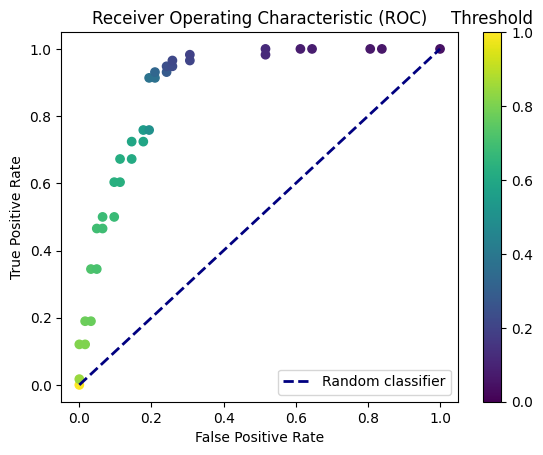

In [15]:
y_val = xgb_model.predict(X_test)

prob_val = xgb_model.predict_proba (X_test)
prob1 = prob_val[:,1]

cm = confusion_matrix(y_test, y_val)

print (cm)

fpr, tpr, thresholds = roc_curve(y_test,prob1)

distance_perfection = []
for i in range (len(fpr)):
    distance_perfection.append(fpr[i]*fpr[i] + (1-tpr[i])*(1-tpr[i]))

threshold = thresholds[distance_perfection.index(min(distance_perfection))]
print ('Threshold: ', threshold)
print ('Operating point: FPR = %lf   TPR = %lf' % (fpr[distance_perfection.index(min(distance_perfection))], tpr[distance_perfection.index(min(distance_perfection))]))

print ('AUC: %lf' % (auc(fpr, tpr)))
plt.figure()
plt.scatter(fpr, tpr, c= thresholds, cmap='viridis', vmin=0, vmax=1)
clb = plt.colorbar()
clb.ax.set_title('Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label= 'Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

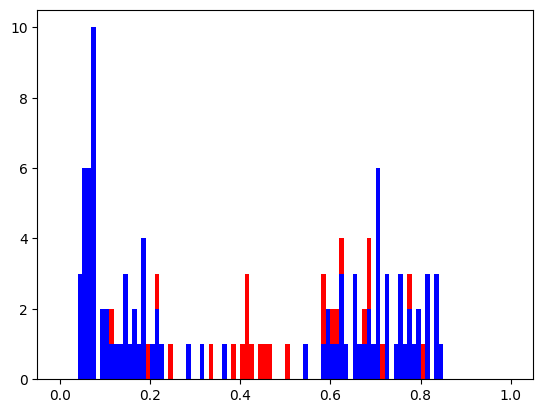

In [16]:
bins = np.arange(0,1.001,0.01)
#print (bins)
hist_aciertos = []
y_val = np.array(y_val); y_test = np.array(y_test)
for i in range(len(y_val)):
    #print (y_val[i],y_test[i])
    if y_val[i]==y_test[i]:
        hist_aciertos.append(prob1[i])

# plotting first histogram
plt.hist(prob1,bins=bins, color='red')

# plotting second histogram
plt.hist(hist_aciertos,bins=bins, color='blue')

# Showing the plot using plt.show()
plt.show()

### Read and preprocess of the test data

In [17]:
test = pd.read_csv('/content/test_A_derma.csv')

In [18]:
test = preprocess(test)
test = crea_unified(test)
test = replace_nan(test,True)

In [19]:
test

,Lession,Genetic Propensity,Skin X test,Skin color,Length,Area
0,-1.0,0.387992,0.666667,-1.0,PM,L
1,-1.0,0.387992,0.666667,1.0,S,S
2,0.0,0.387992,1.000000,-1.0,PS,PM
3,0.0,0.387992,0.333333,1.0,M,M
4,1.0,0.373318,1.000000,1.0,M,M
...,...,...,...,...,...,...
251,0.0,0.296499,0.666667,0.0,PL,L
252,-1.0,0.303514,1.000000,1.0,L,L
253,0.0,0.299477,0.666667,-1.0,L,L
254,0.0,0.387992,0.666667,-1.0,S,S


In [20]:
preds = xgb_model.predict_proba(test)

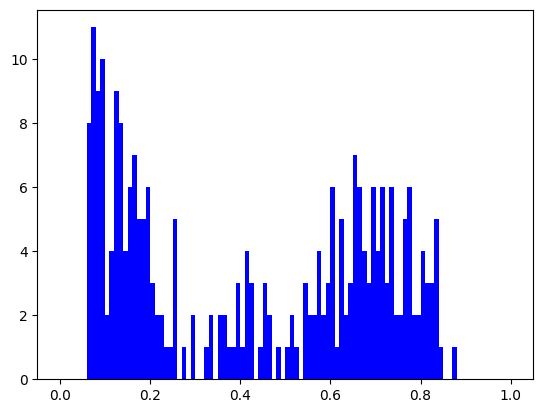

In [21]:
plt.hist(preds[:,1],bins=bins, color='blue')
plt.show()

### Decision on the intervals of probability that will be used for the data augmentation

In [22]:
y = list(y)
#print(test)
for i in range (len(preds)):
    if preds[i][1] <= 0.08:
        #print (preds[i][1])
        X.loc[len(X.index)] = test.values[i]
        y.append(0)
    #if preds[i][1] >= 0.99:
        #print (preds[i][1])
        #X.loc[len(X.index)] = test.values[i]
        #y.append(1)

print (len(X), len(y))

616 616


## Second training with both training and some of the test samples

In [27]:
X['Area'] = X['Area'].astype('category')
X['Length'] = X['Length'].astype('category')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(5, 15, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int))
}

# Define the objective function to minimize
def objective(params):
    xgb_model2 = xgb.XGBClassifier(**params, enable_categorical=True, tree_method='hist')
    xgb_model2.fit(X_train, y_train)
    y_pred = xgb_model2.predict(X_test)
    y_pred_prob = xgb_model2.predict_proba(X_test)
    score = accuracy_score(y_test, y_pred)
    #score = (y_pred @ np.log(y_pred_prob[:,1]) + (np.ones(len(y_pred)) - y_pred) @ np.log(np.ones(len(y_pred)) - y_pred_prob[:,1]))
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 500/500 [01:56<00:00,  4.28trial/s, best loss: -0.8548387096774194]
Best set of hyperparameters:  {'learning_rate': 0.04230687147793261, 'max_depth': 0, 'n_estimators': 207, 'subsample': 0.3182503886935578}


In [30]:
xgb_model2 = xgb.XGBClassifier(**best_params, enable_categorical=True, tree_method='hist')
xgb_model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04230687147793261,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=207, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

[[61 10]
 [12 41]]
Operating point: FPR = 0.169014   TPR = 0.905660
AUC: 0.902073


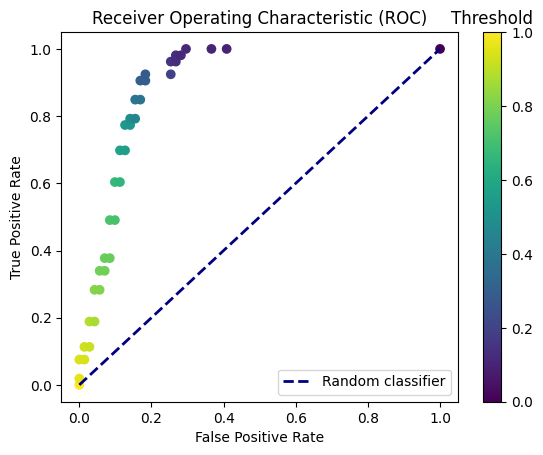

Threshold:  0.30117226


In [31]:
y_val = xgb_model2.predict(X_test)

prob_val = xgb_model2.predict_proba (X_test)
prob1 = prob_val[:,1]

cm = confusion_matrix(y_test, y_val)

print (cm)

fpr, tpr, thresholds = roc_curve(y_test,prob1)

distance_perfection = []
for i in range (len(fpr)):
    distance_perfection.append(fpr[i]*fpr[i] + (1-tpr[i])*(1-tpr[i]))

threshold = thresholds[distance_perfection.index(min(distance_perfection))]
print ('Operating point: FPR = %lf   TPR = %lf' % (fpr[distance_perfection.index(min(distance_perfection))], tpr[distance_perfection.index(min(distance_perfection))]))

print ('AUC: %lf' % (auc(fpr, tpr)))
plt.figure()
plt.scatter(fpr, tpr, c= thresholds, cmap='viridis', vmin=0, vmax=1)
clb = plt.colorbar()
clb.ax.set_title('Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label= 'Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
print ('Threshold: ', threshold)

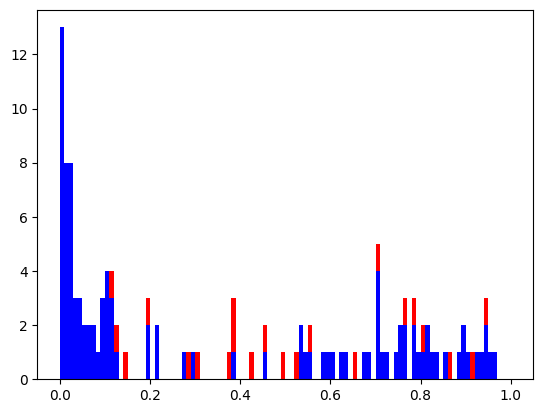

In [32]:
bins = np.arange(0,1.001,0.01)
#print (bins)
hist_aciertos = []
y_val = np.array(y_val); y_test = np.array(y_test)
for i in range(len(y_val)):
    #print (y_val[i],y_test[i])
    if y_val[i]==y_test[i]:
        hist_aciertos.append(prob1[i])

# plotting first histogram
plt.hist(prob1,bins=bins, color='red')

# plotting second histogram
plt.hist(hist_aciertos,bins=bins, color='blue')

# Showing the plot using plt.show()
plt.show()

## Prediction of the test dataset using the model obtained in the second training

In [33]:
preds2 = xgb_model2.predict_proba(test)

In [34]:
ids = []
predictions = []
for i in range (len(preds2)):
    ids.append(i)
    if preds2[i][1] > threshold:
        predictions.append('real')
    else:
        predictions.append('fake')

In [35]:
#predictions

In [36]:
d = {'Id': ids, 'Prediction': predictions}
df = pd.DataFrame(data=d)
df.to_csv('/content/XGBoost Quitando NaN Operating Point UnifiedMeasure 2pasadas.csv', index=False)

# Dataset B (Text)

## Reading train and test datasets

In [37]:
colnames=['Id', 'Title', 'Label']
dftrain = pd.read_csv('/content/train_B_text.csv', names=colnames, header=0)
coltest = ['Id', 'Title']
dftest = pd.read_csv('/content/test_B_text.csv', names=coltest, header=0)

In [38]:
dftrain['Label'] = dftrain['Label'].replace ('fake', 0)
dftrain['Label'] = dftrain['Label'].replace ('real', 1)

In [39]:
X = []
Y = []
X_test = []

for i in range (len(dftrain['Id'])):
    X.append(dftrain['Title'][i])
    Y.append(dftrain['Label'][i])

for i in range (len(dftest['Id'])):
    X_test.append(dftest['Title'][i])

## First training of the training dataset in order to determine which samples of the test dataset will be used later in the second training

### Import tokenizer and model of distilbert

In [40]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Preprocessing of the datasets

In [41]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2)
token_train = [str(i) for i in X_train]
token_val = [str(i) for i in X_val]
token_test = [str(i) for i in X_test]

In [42]:
train_encodings = tokenizer(token_train, truncation = True, padding = True)
val_encodings = tokenizer(token_val, truncation = True, padding = True)
test_encodings = tokenizer(token_test, truncation = True, padding = True)

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))

### Model definition, compile and fit

In [44]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

#compile the model
model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

#train the model
model.fit(train_dataset.batch(16),
          epochs=2,
          batch_size=16,
          validation_data=val_dataset.batch(16), verbose = 1)

Epoch 1/2
175/175 [==============================] - 46s 121ms/step - loss: 0.1575 - accuracy: 0.9524 - val_loss: 0.1355 - val_accuracy: 0.9543
Epoch 2/2
175/175 [==============================] - 16s 94ms/step - loss: 0.0878 - accuracy: 0.9678 - val_loss: 0.1084 - val_accuracy: 0.9629


### Validation and test results

In [45]:
predictions = model.predict(val_dataset)
testresults = model.predict(test_dataset)

1500/1500 [==============================] - 9s 6ms/step


[[133  20]
 [  6 541]]

Sensibilidad: 98.90
Especificidad: 86.93
Threshold:  0.7915543
Operating point: FPR = 0.078431   TPR = 0.930530
AUC: 0.985184


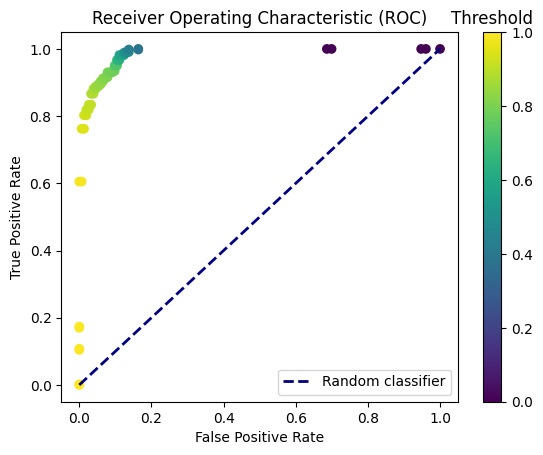

In [46]:
output = []
prob0 = []
prob1 = []

for i in range (len(X_val)):
    if predictions[0][i][0] > predictions[0][i][1]:
        output.append(0)
    else:
        output.append(1)

    suma = np.exp(predictions[0][i][0])+np.exp(predictions[0][i][1])
    prob0.append(np.exp(predictions[0][i][0])/suma)
    prob1.append(np.exp(predictions[0][i][1])/suma)


cm = confusion_matrix(Y_val,output)

print(cm)

especificidad = cm[0][0] / (cm[0][0] + cm[0][1]) * 100
sensibilidad = cm[1][1] / (cm[1][1] + cm[1][0]) * 100

print ('\nSensibilidad: %.2lf' % sensibilidad)
print ('Especificidad: %.2lf' % especificidad)

fpr, tpr, thresholds = roc_curve(Y_val,prob1)

distance_perfection = []
for i in range (len(fpr)):
    distance_perfection.append(fpr[i]*fpr[i] + (1-tpr[i])*(1-tpr[i]))

threshold = thresholds[distance_perfection.index(min(distance_perfection))]

print ('Threshold: ', threshold)
print ('Operating point: FPR = %lf   TPR = %lf' % (fpr[distance_perfection.index(min(distance_perfection))], tpr[distance_perfection.index(min(distance_perfection))]))

print ('AUC: %lf' % (auc(fpr, tpr)))
plt.figure()
plt.scatter(fpr, tpr, c= thresholds, cmap='viridis', vmin=0, vmax=1)
clb = plt.colorbar()
clb.ax.set_title('Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label= 'Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

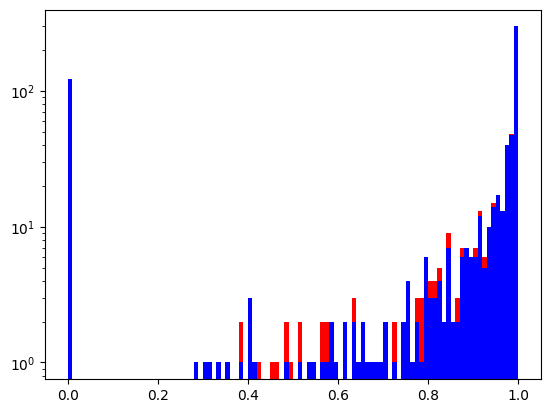

In [47]:
bins = np.arange(0,1.001,0.01)
#print (bins)
hist_aciertos = []
Y_val = np.array(Y_val); output = np.array(output)
for i in range(len(Y_val)):
    #print (y_val[i],y_test[i])
    if Y_val[i]==output[i]:
        hist_aciertos.append(prob1[i])

# plotting first histogram
plt.hist(prob1,bins=bins, color='red')

# plotting second histogram
plt.hist(hist_aciertos,bins=bins, color='blue')

# Showing the plot using plt.show()
plt.yscale('log')
plt.show()

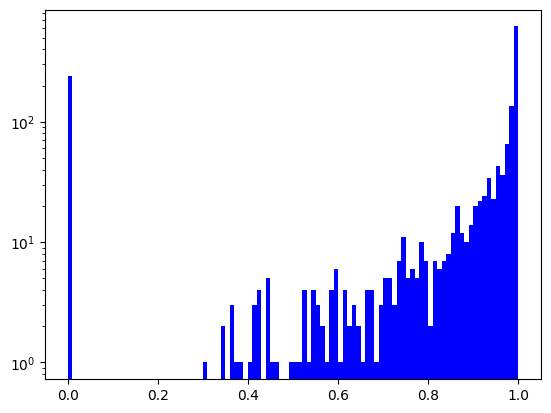

In [48]:
prob1test = [np.exp(p)/(np.exp(p) + np.exp(q)) for q,p in zip (testresults.logits[:,0], testresults.logits[:,1])]
plt.hist(prob1test,bins=bins, color='blue')
plt.yscale('log')
plt.show()

## Second training

### Definition of the interval of probability that decides which test samples will be used for training

In [49]:
for i in range (len(testresults.logits)):
    if testresults.logits[i][1] < 0.05:
        X.append(X_test[i])
        Y.append(0)
    elif testresults.logits[i][1] > 0.95:
        X.append(X_test[i])
        Y.append(1)

print (len(X),len(Y))

4827 4827


### Preprocess of the new training and validation datasets

In [50]:
X_train_2pasada, X_val_2pasada, Y_train_2pasada, Y_val_2pasada = train_test_split(X,Y,test_size=0.2)

token_train_2pasada = [str(i) for i in X_train_2pasada]
token_val_2pasada = [str(i) for i in X_val_2pasada]

train_2pasada_encodings = tokenizer(token_train_2pasada, truncation = True, padding = True)
val_2pasada_encodings = tokenizer(token_val_2pasada, truncation = True, padding = True)

train_2pasada_dataset = tf.data.Dataset.from_tensor_slices((dict(train_2pasada_encodings), Y_train_2pasada))
val_2pasada_dataset = tf.data.Dataset.from_tensor_slices((dict(val_2pasada_encodings), Y_val_2pasada))

### Definition of the model, loss, optimizer and fit

In [59]:
model_2pasada = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-cased")

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

#compile the model
model_2pasada.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

#train the model
model_2pasada.fit(train_2pasada_dataset.batch(16),
          epochs=1,
          batch_size=16,
          validation_data=val_2pasada_dataset.batch(16), verbose = 1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

242/242 [==============================] - 47s 114ms/step - loss: 0.1321 - accuracy: 0.9560 - val_loss: 0.0813 - val_accuracy: 0.9710


### Validation and test results

In [60]:
predictions_2pasada = model_2pasada.predict(val_2pasada_dataset)
testresults_2pasada = model_2pasada.predict(test_dataset)

1500/1500 [==============================] - 11s 6ms/step


[[167  22]
 [  6 771]]

Sensibilidad: 99.23
Especificidad: 88.36
Threshold:  0.63291824
Operating point: FPR = 0.052910   TPR = 0.971686
AUC: 0.991127


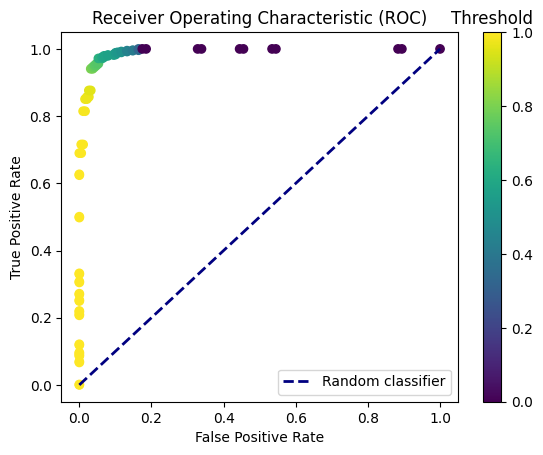

In [61]:
output_2pasada = []
prob0_2pasada = []
prob1_2pasada = []

for i in range (len(X_val_2pasada)):
    if predictions_2pasada[0][i][0] > predictions_2pasada[0][i][1]:
        output_2pasada.append(0)
    else:
        output_2pasada.append(1)

    suma = np.exp(predictions_2pasada[0][i][0])+np.exp(predictions_2pasada[0][i][1])
    prob0_2pasada.append(np.exp(predictions_2pasada[0][i][0])/suma)
    prob1_2pasada.append(np.exp(predictions_2pasada[0][i][1])/suma)


cm_2pasada = confusion_matrix(Y_val_2pasada,output_2pasada)

print(cm_2pasada)

especificidad_2pasada = cm_2pasada[0][0] / (cm_2pasada[0][0] + cm_2pasada[0][1]) * 100
sensibilidad_2pasada = cm_2pasada[1][1] / (cm_2pasada[1][1] + cm_2pasada[1][0]) * 100

print ('\nSensibilidad: %.2lf' % sensibilidad_2pasada)
print ('Especificidad: %.2lf' % especificidad_2pasada)

fpr_2pasada, tpr_2pasada, thresholds_2pasada = roc_curve(Y_val_2pasada,prob1_2pasada)

distance_perfection_2pasada = []
for i in range (len(fpr_2pasada)):
    distance_perfection_2pasada.append(fpr_2pasada[i]*fpr_2pasada[i] + (1-tpr_2pasada[i])*(1-tpr_2pasada[i]))

threshold_2pasada = thresholds_2pasada[distance_perfection_2pasada.index(min(distance_perfection_2pasada))]

print ('Threshold: ', threshold_2pasada)
print ('Operating point: FPR = %lf   TPR = %lf' % (fpr_2pasada[distance_perfection_2pasada.index(min(distance_perfection_2pasada))], tpr_2pasada[distance_perfection_2pasada.index(min(distance_perfection_2pasada))]))

print ('AUC: %lf' % (auc(fpr_2pasada, tpr_2pasada)))
plt.figure()
plt.scatter(fpr_2pasada, tpr_2pasada, c= thresholds_2pasada, cmap='viridis', vmin=0, vmax=1)
clb = plt.colorbar()
clb.ax.set_title('Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label= 'Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

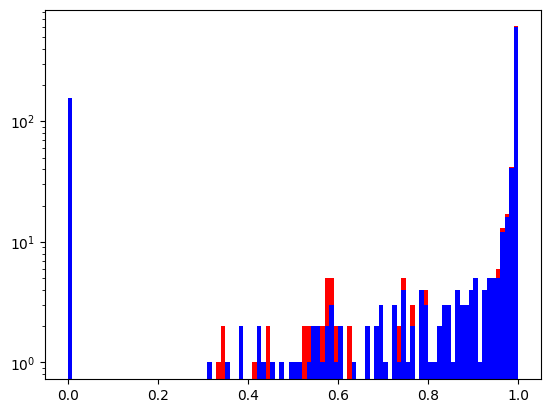

In [62]:
bins = np.arange(0,1.001,0.01)
#print (bins)
hist_2pasada_aciertos = []
Y_val_2pasada = np.array(Y_val_2pasada); output_2pasada = np.array(output_2pasada)
for i in range(len(Y_val_2pasada)):
    #print (y_val[i],y_test[i])
    if Y_val_2pasada[i]==output_2pasada[i]:
        hist_2pasada_aciertos.append(prob1_2pasada[i])

plt.figure()
# plotting first histogram
plt.hist(prob1_2pasada,bins=bins, color='red')

# plotting second histogram
plt.hist(hist_2pasada_aciertos,bins=bins, color='blue')

# Showing the plot using plt.show()
plt.yscale('log')
plt.show()

In [63]:
labelfinal = []

for i in range (len(testresults_2pasada.logits)):
    if testresults_2pasada.logits[i][1] > threshold_2pasada:
        labelfinal.append('real')
    else:
        labelfinal.append('fake')

d = {'Id': dftest['Id'], 'Prediction': labelfinal}
df = pd.DataFrame(data=d)
df.to_csv('/content/DistilBERT Base Cased 2ep Operating Point 2pasadas.csv', index=False)

# Mixing both final results

In [64]:
colnames = ['Id', 'Prediction']

dfA = pd.read_csv('/content/XGBoost Quitando NaN Operating Point UnifiedMeasure 2pasadas.csv', names = colnames, header = 0)
dfB = pd.read_csv('/content/DistilBERT Base Cased 2ep Operating Point 2pasadas.csv', names = colnames, header = 0)

print (len(dfA['Prediction']))
print (len(dfB['Prediction']))

predictions_combined = np.concatenate((dfA['Prediction'], dfB['Prediction']))

ids_combined = []
for i in range (len(predictions_combined)):
    ids_combined.append(i)

print (len(ids_combined))

d = {'Id': ids_combined, 'Prediction': predictions_combined}
df = pd.DataFrame(data=d)

df.to_csv('/content/Final_Results_DavidIniguez_JaumeSanchez.csv', index = False)

256
1500
1756
